In [47]:
# Import and install dependencies
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
# Python 3.10* needed.
#! pip install tensorflow==2.11.* tensorflow-io==0.31.0 matplotlib

In [48]:
# imports and constants
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import librosa
import librosa.display
import numpy as np
from scipy.io import wavfile as wav
import IPython.display as ipd

DATA_DIR = 'D:\Code\ProjectsPython\ML_TrainingGround\ML_Audio\data'
METADATA = os.path.join(DATA_DIR, "UrbanSound8K", "metadata", "UrbanSound8K.csv")
AUDIO_DIR = os.path.join(DATA_DIR, "UrbanSound8K", "audio")
SAMPLE_RATE = 16000

In [49]:
import struct
import librosa
import numpy as np

def read_file_properties(filename):

    wave_file = open(filename, "rb")
    
    riff = wave_file.read(12)
    fmt = wave_file.read(36)
    
    num_channels_string = fmt[10:12]
    num_channels = struct.unpack('<H', num_channels_string)[0]

    sample_rate_string = fmt[12:16]
    sample_rate = struct.unpack("<I", sample_rate_string)[0]
    
    bit_depth_string = fmt[22:24]
    bit_depth = struct.unpack("<H", bit_depth_string)[0]
    
    wave_file.close()

    # Load the audio file with librosa
    y, sr = librosa.load(filename, sr=SAMPLE_RATE, mono=True)  # Load as mono

    # Compute RMS of the audio signal using librosa
    # rms = librosa.feature.rms(y=y)[0]
    # avg_rms = np.mean(rms)  # Average RMS over time if needed
    avg_rms = None
    # Compute the length of the audio sample in seconds
    length_in_seconds = len(y) / sr  # Total samples / Sample rate
    
    # Length in samples
    length_in_samples = len(y)
    
    return (num_channels, sample_rate, bit_depth, avg_rms, length_in_seconds, length_in_samples)  # Added length_in_samples

<h3><i>Observe the Dataset</i></h3>

In [50]:
AUDIO01 = os.path.join(AUDIO_DIR, "fold1/101415-3-0-2.wav")
AUDIO02 = os.path.join(AUDIO_DIR, "fold10/2937-1-0-0.wav")

<p><b>Dataset metadata</b></p>

In [51]:
df = pd.read_csv(METADATA)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<p><b>Class distribution</b></p>

In [52]:
print(df["class"].value_counts())

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


**Diversity in sample properties**
*  Number of channels  
*  Sample rates
*  Bit depths

In [53]:
audiodata = []
for index, row in df.iterrows():
    
    file_name = os.path.join(AUDIO_DIR,'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = read_file_properties(file_name)
    audiodata.append(data)
    # Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=["num_channels", "sample_rate", "bit_depth", "avg_rms", "length_in_seconds", "length_in_samples"])

In [54]:
audiodf.head()

# num of channels 
print("Channels: ")
print(audiodf.num_channels.value_counts(normalize=True))

# sample rates 
print("Sample Rates: ")
print(audiodf.sample_rate.value_counts(normalize=True))

# bit depth
print("Bit Depth: ")
print(audiodf.bit_depth.value_counts(normalize=True))

# length in samples
print("Samples: ")
print(audiodf.length_in_samples.value_counts())

# RMS
# print(audiodf.avg_rms.describe())

Channels: 
num_channels
2    0.915369
1    0.084631
Name: proportion, dtype: float64
Sample Rates: 
sample_rate
44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: proportion, dtype: float64
Bit Depth: 
bit_depth
16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: proportion, dtype: float64
Samples: 
length_in_samples
64000    7325
21280      10
23040      10
17440       9
15200       7
         ... 
17749       1
26032       1
37864       1
39638       1
56096       1
Name: count, Length: 947, dtype: int64


### Preprocessing with Librosa
* Resample to common sample rate
* Bit-depth Normalization
* Mix-down to mono channel

In [55]:
# Resample
filename = AUDIO01

librosa_audio, librosa_sample_rate = librosa.load(filename, sr=SAMPLE_RATE)
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 48000
Librosa sample rate: 16000


In [56]:
#Bit-depth 
# Librosa’s load function will also normalise the data so it's values range between -1 and 1. This removes the complication of the dataset having a wide range of bit-depths.

print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -27967 to 26427
Librosa audio file min~max range: -0.8544729 to 0.80603814


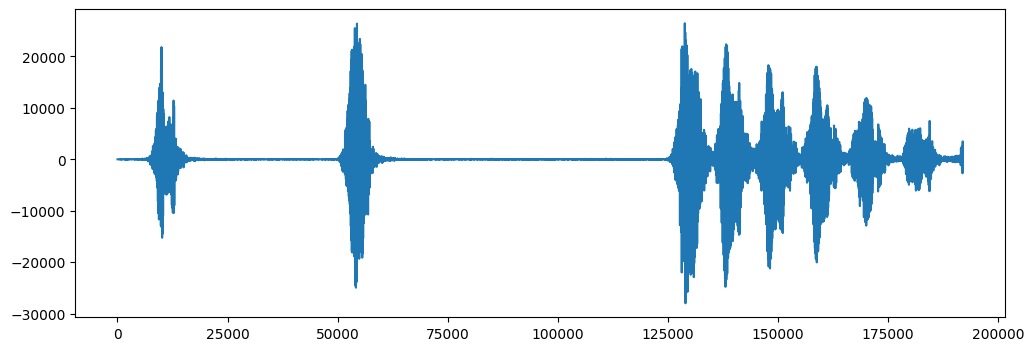

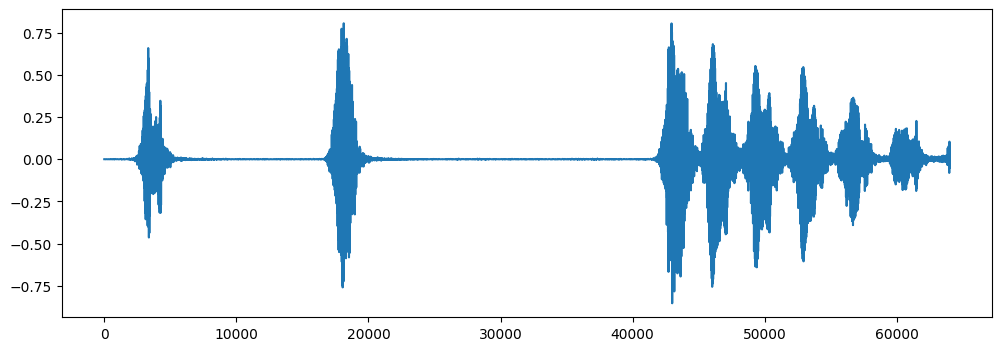

In [57]:
# Mix down to mono

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

In [58]:
# Slice for common length of 1 seconds
def slice_audio(librosa_audio, librosa_sample_rate = SAMPLE_RATE):
    SAMPLE_LENGTH = 2 * librosa_sample_rate

    librosa_audio_sliced = librosa_audio[:SAMPLE_LENGTH]
    if len(librosa_audio) < SAMPLE_LENGTH:
        # print(f"Audio length {len(librosa_audio)} is less than 2 seconds. Padding with zeros.")
        # np.pad specifies the number of values to add at the beginning and the end of the librosa_audio array.
        # 0 -> no padding in the beginning.
        # SAMPLE_LENGTH - len(librosa_audio) -> number of zeros to end, ensuring the total length is 2 seconds.
        librosa_audio_sliced = np.pad(librosa_audio, (0, SAMPLE_LENGTH - len(librosa_audio)), constant_values=0)
    return librosa_audio_sliced

# print(f"Librosa audio before: {librosa_audio.shape} and after: {slice_audio(librosa_audio).shape}")

# ______________________________________________________________________________
## <i>FEATURE EXTRACTION:</i>

### Option 1
**Extract MFCCs**

(40, 63)


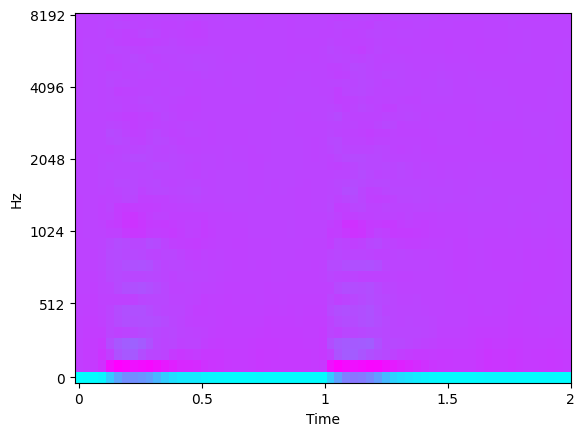

In [59]:
librosa_audio = slice_audio(librosa_audio, SAMPLE_RATE)
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=SAMPLE_RATE, n_mfcc=40)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=SAMPLE_RATE, x_axis='time', cmap='cool', y_axis='mel')

In [60]:
from IPython.display import Audio

Audio(data=slice_audio(librosa_audio), rate=SAMPLE_RATE)

In [61]:
# Extract MFCC features function
#! pip install resampy

max_pad_len = 174

def extract_mfccs(audio_path):
    audio_file, librosa_sample_rate = librosa.load(audio_path, sr=SAMPLE_RATE, res_type='kaiser_fast')
    audio_file = slice_audio(audio_file, librosa_sample_rate)
    mfccs = librosa.feature.mfcc(y=audio_file, sr=SAMPLE_RATE, n_mfcc=40)

    return mfccs

In [62]:
features = []

# Iterate through each sound file and extract the features 
for index, row in df.iterrows():
    
    file = os.path.join(AUDIO_DIR, "fold" + str(row["fold"]) + "\\" + str(row["slice_file_name"]))
    class_label = row["class"]
    data = extract_mfccs(file)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  8732  files


In [63]:
featuresdf.head()

,feature,class_label
0,"[[-249.21655, -116.725845, -58.913345, -42.339...",dog_bark
1,"[[-473.87863, -435.08136, -426.31833, -413.208...",children_playing
2,"[[-476.2951, -450.132, -458.75067, -460.36163,...",children_playing
3,"[[-426.3559, -391.4059, -389.78726, -400.58566...",children_playing
4,"[[-445.6946, -415.8736, -417.45618, -411.40588...",children_playing


In [64]:
featuresdf.iloc[0]['feature'].shape

(40, 63)

#### <i>END OF FEATURE EXTRACTION</i>
# ______________________________________________________________________________

**Convert the data and labels**
<p>We will use sklearn.preprocessing.LabelEncoder to encode the categorical text data into model-understandable numerical data.</p>
<p><i>Meaning, that every class has a column, which is either 0 or 1</i></p>

In [65]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

### Split the dataset

In [66]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

<b>Store the preprocessed data</b>

In [67]:
### store the preprocessed data for use in the next notebook

%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)
